In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pprint
import os
import sys
import h5py
import pandas as pd
import progressbar
import warnings
import time
import scipy

# set paths
# got these from here: https://github.com/AllenInstitute/visual_coding_2p_analysis/blob/master/visual_coding_2p_analysis/core.py
save_path = "/Volumes/programs/braintv/workgroups/cortexmodels/michaelbu/ObservatoryPlatformPaperAnalysis/event_analysis_files_2018_09_25" 
manifest_file = "/Volumes/programs/braintv/workgroups/cortexmodels/michaelbu/ObservatoryPlatformPaperAnalysis/platform_boc_2018_09_25/manifest.json"

# retrieve data cache
boc = BrainObservatoryCache(manifest_file=manifest_file)

/Users/imanwahle/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [17]:
# constants
methods = ['knn', 'svm', 'lda', 'gnb', 'mlg', 'mlp', 'ncc', 'qda', 'rfc']
mouse_sizes = [5,10,15,20,25,30,35,40,45,50,55,75,100,150,300]
miter = 5 # number of times to sample mice of given size
niter = 100 # number of times to sample ndrns to replace ndsns

In [3]:
# paths
path = "/Volumes/programs/braintv/workgroups/nc-ophys/Iman/direction_flipping/stimulus_classification/"
dfp = path + "results/megamice/"

In [9]:
# data1 = np.load(dfp + "megamice_results150_set1.npy")
# data2 = np.load(dfp + "megamice_results150_set2.npy")

# results = np.zeros((len(mouse_sizes), miter, 160, niter, len(methods), 2))
# results[:,0:3] = data1
# results[:,3:] = data2
# # results[:,2] = data3
# # results[:,3] = data4
# # results[:,4] = data5

# np.save(dfp + "megamice_results150.npy", results)

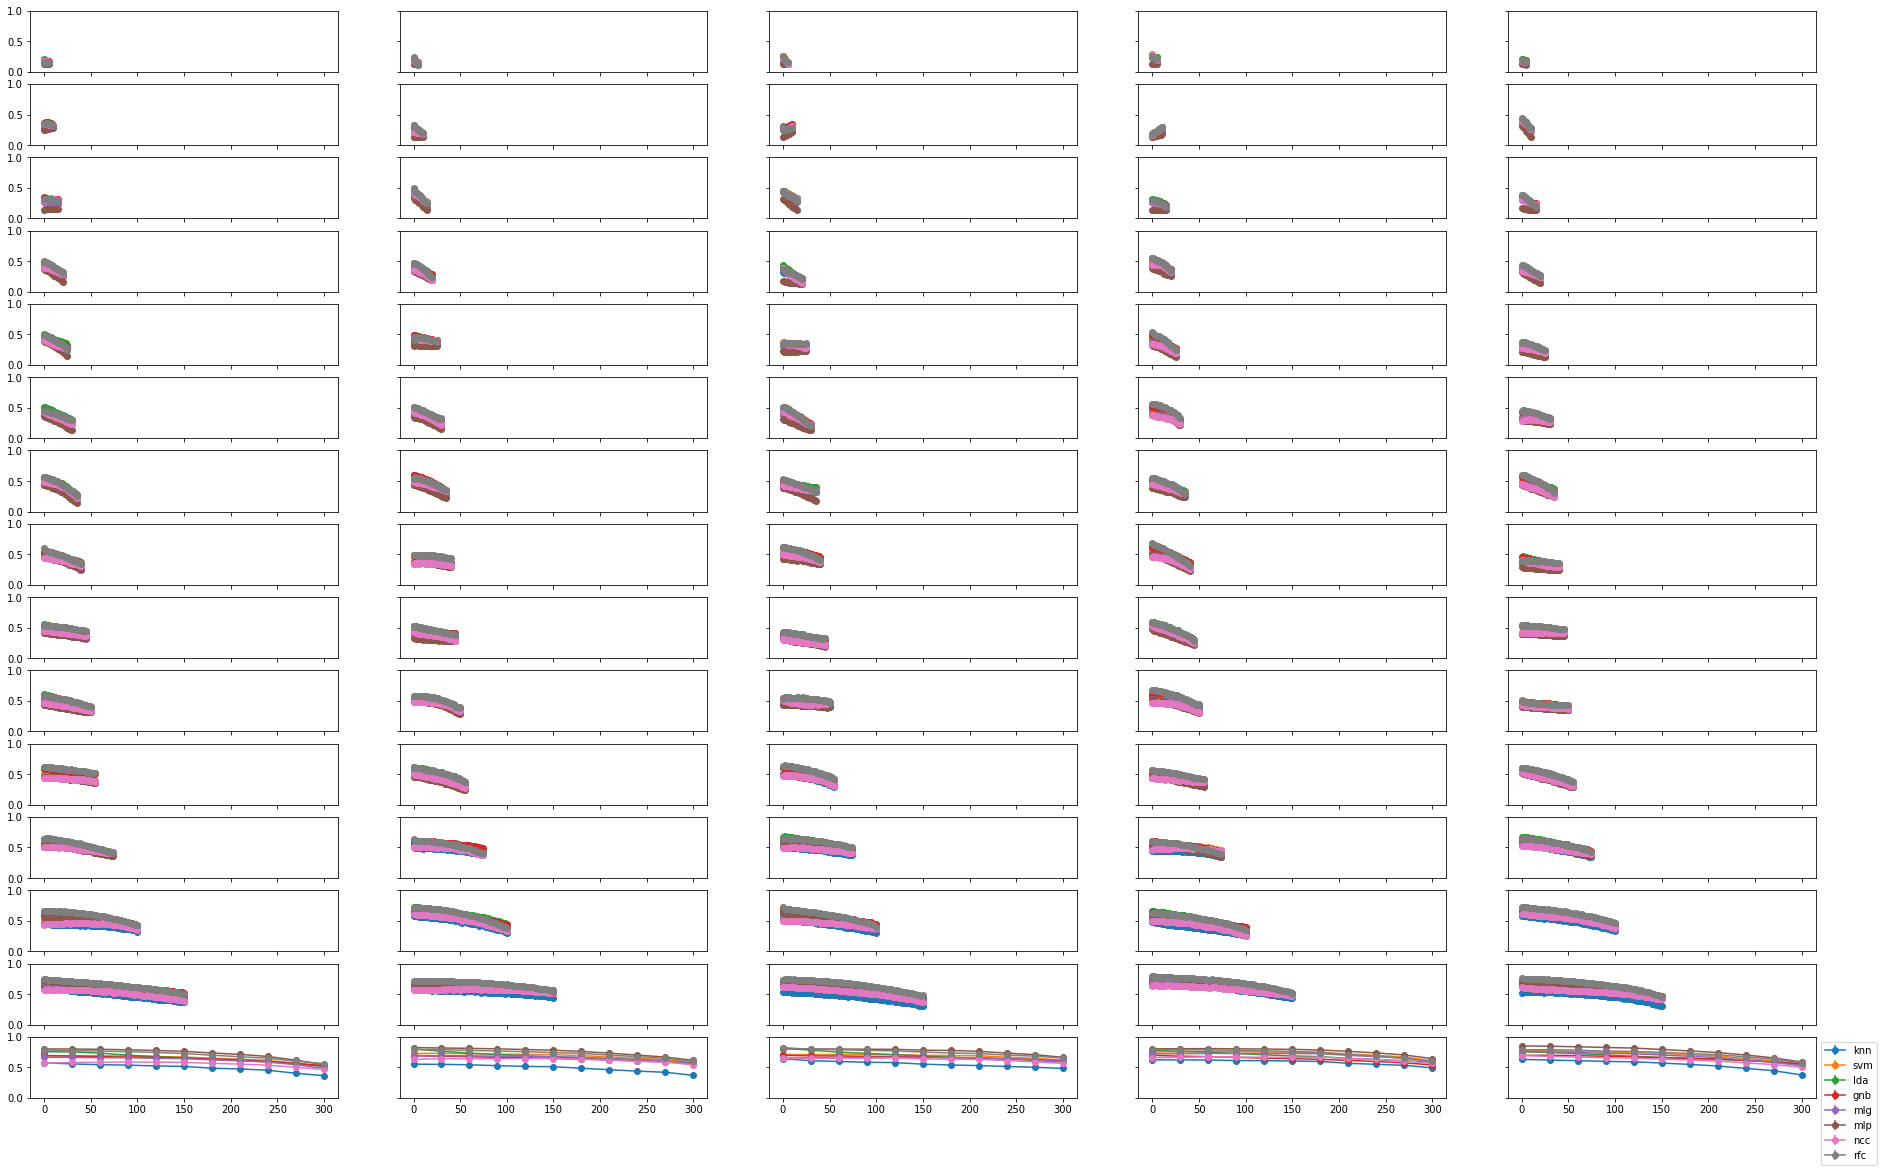

In [18]:
fig, ax = plt.subplots(len(mouse_sizes), miter, sharex='all', sharey='all',figsize=(32,20))
for msi,ms in enumerate(mouse_sizes):

    data = np.load(dfp + "megamice_results" + str(ms) + ".npy")
    for mi in range(miter):
        for m,method in enumerate(methods):
            if method=="qda":
                continue
            # pull out data for this mouse and method
            raw_accs = data[0,mi,:,:,m,1]
            mean_acc = np.mean(raw_accs, axis=1)
            sem_acc = scipy.stats.sem(raw_accs, axis=1)
            mean_acc = mean_acc[~np.isnan(mean_acc)]
            sem_acc = sem_acc[~np.isnan(sem_acc)]
            if ms in [75,100,150]:
                x = range(0,2*len(mean_acc),2)
            elif ms in [300, 314]:
                x = range(0,30*len(mean_acc), 30)
            elif ms in [1000]:
                x = range(0,100*len(mean_acc), 100)
            elif ms in [2000]:
                x = range(0,200*len(mean_acc), 200)
            else:
                x = range(len(mean_acc))
            ax[msi,mi].errorbar(x, 
                                mean_acc, 
                                yerr=sem_acc, 
                                fmt='-o', 
                                label=method,
                                #color=colors[m]
                                )

            # plt.title("Acc, Mouse: " + str(mi) + ", #DRNs: " + str(len(x)-1) + ", #Cells: TODO")

            # plt.xlabel("# DRNs")
            # plt.ylabel("Accuracy")
lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.savefig(path + "analysis/helpful_by_areal_deep.svg", bbox_inches='tight',transparent=True)
plt.ylim((0,1))
plt.show()

In [19]:
fits = np.zeros((len(mouse_sizes), miter, len(methods), 2))
fits[:] = np.nan
half1_fits = np.zeros((len(mouse_sizes), miter, len(methods), 2))
half1_fits[:] = np.nan
half2_fits = np.zeros((len(mouse_sizes), miter, len(methods), 2))
half2_fits[:] = np.nan
polyfits = np.zeros((len(mouse_sizes), miter, len(methods), 3))
polyfits[:] = np.nan

for msi,ms in enumerate(mouse_sizes):

    data = np.load(dfp + "megamice_results" + str(ms) + ".npy")     
        
    for mi in range(miter):
        for m,method in enumerate(methods):
            # pull out data for this mouse and method
            raw_accs = data[0,mi,:,:,m,1]
            mean_acc = np.mean(raw_accs, axis=1)
            mean_acc = mean_acc[~np.isnan(mean_acc)]
            if ms in [75,100,150]:
                x = range(0,2*len(mean_acc),2)
            elif ms in [300, 314]:
                x = range(0,30*len(mean_acc), 30)
            elif ms in [1000]:
                x = range(0,100*len(mean_acc), 100)
            elif ms in [2000]:
                x = range(0,200*len(mean_acc), 200)
            else:
                x = range(len(mean_acc))
            half = len(x)/2
            slope_all, intercept_all, r_value_all, pval_all, std_err_all = scipy.stats.linregress(x,mean_acc)
            slope_half1, intercept_half1, r_value_half1, pval_half1, std_err_half1 = scipy.stats.linregress(x[:half],mean_acc[:half])
            slope_half2, intercept_half2, r_value_half2, pval_half2, std_err_half2 = scipy.stats.linregress(x[half:],mean_acc[half:])

            fits[msi,mi,m,:] = [slope_all, pval_all]
            half1_fits[msi,mi,m,:] = [slope_half1, pval_half1]
            half2_fits[msi,mi,m,:] = [slope_half2, pval_half2]
            pbetas = np.polyfit(x,mean_acc,2)
            polyfits[msi,mi,m,:] = pbetas

In [20]:
# remove qda
fits = fits[:,:,[0,1,2,3,4,5,6,8],:]

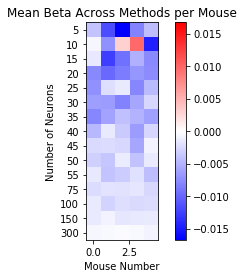

In [35]:
fig, ax = plt.subplots()
to_plot = np.mean(fits[:,:,:,0],axis=2)
plt.imshow(to_plot,cmap="bwr",vmin=np.min(to_plot[~np.isnan(to_plot)]), vmax=-np.min(to_plot[~np.isnan(to_plot)]))
ax.set_yticks(range(len(mouse_sizes)))
ax.set_yticklabels(np.array(mouse_sizes).astype(str))
plt.xlabel("Mouse Number")
plt.ylabel("Number of Neurons")
plt.colorbar()
#plt.clim()
plt.title("Mean Beta Across Methods per Mouse")
plt.savefig(path + "presentation_figures/megamice_betas.svg",bbox_inches='tight',transparent=True)
plt.show()

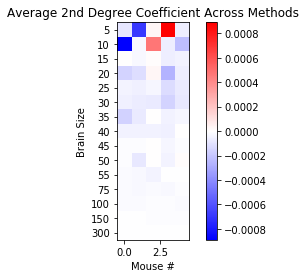

In [22]:
fig, ax = plt.subplots()
to_plot = np.mean(polyfits[:,:,:,0],axis=2)
plt.imshow(to_plot,cmap="bwr",vmin=np.min(to_plot[~np.isnan(to_plot)]), vmax=-np.min(to_plot[~np.isnan(to_plot)]))
ax.set_yticks(range(len(mouse_sizes)))
ax.set_yticklabels(np.array(mouse_sizes).astype(str))
plt.xlabel("Mouse #")
plt.ylabel("Brain Size")
plt.colorbar()
#plt.clim()
plt.title("Average 2nd Degree Coefficient Across Methods")
plt.show()

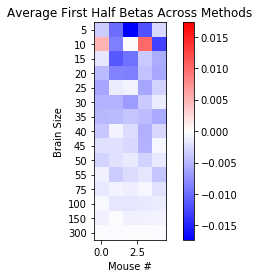

In [23]:
fig, ax = plt.subplots()
to_plot = np.mean(half1_fits[:,:,:,0],axis=2)
plt.imshow(to_plot,cmap="bwr",vmin=np.min(to_plot[~np.isnan(to_plot)]), vmax=-np.min(to_plot[~np.isnan(to_plot)]))
ax.set_yticks(range(len(mouse_sizes)))
ax.set_yticklabels(np.array(mouse_sizes).astype(str))
plt.xlabel("Mouse #")
plt.ylabel("Brain Size")
plt.colorbar()
#plt.clim()
plt.title("Average First Half Betas Across Methods")
plt.show()

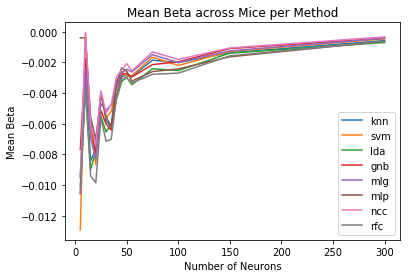

In [36]:
methods2 = ['knn', 'svm', 'lda', 'gnb', 'mlg', 'mlp', 'ncc', 'rfc']
for m,method in enumerate(methods2):
    to_plot = fits[:,:,m,0]
    plt.plot((mouse_sizes), np.nanmean(to_plot,axis=1),label=method)
plt.xlabel("Number of Neurons")
plt.ylabel("Mean Beta")
plt.title("Mean Beta across Mice per Method")
plt.legend()
#plt.xlim((0,110))
plt.savefig(path + "presentation_figures/megamice_betas_method.svg",bbox_inches='tight',transparent=True)
plt.show()

In [25]:
difs = np.zeros((len(mouse_sizes),miter))
for msi,ms in enumerate(mouse_sizes):
    data = np.load(dfp + "megamice_results" + str(ms) + ".npy")     
    for mi in range(miter):
        mouse_difs = []
        for mei,method in enumerate(methods):
            if method=="qda":
                continue
            # pull out data for this mouse and method
            raw_accs = data[0,mi,:,:,mei,1]
            mean_acc = np.mean(raw_accs, axis=1)
            mean_acc = mean_acc[~np.isnan(mean_acc)]
            mouse_difs.append(mean_acc[-1] - mean_acc[0])
        difs[msi,mi] = np.mean(mouse_difs)

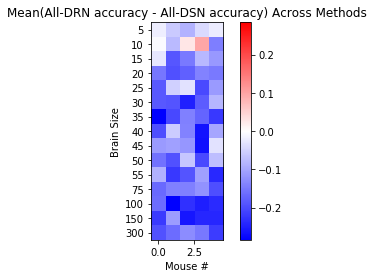

In [26]:
fig, ax = plt.subplots()
plt.imshow(difs,cmap='bwr',vmin=np.min(difs), vmax=-np.min(difs))
ax.set_yticks(range(len(mouse_sizes)))
ax.set_yticklabels(np.array(mouse_sizes).astype(str))
plt.xlabel("Mouse #")
plt.ylabel("Brain Size")
plt.colorbar()
plt.title("Mean(All-DRN accuracy - All-DSN accuracy) Across Methods")
plt.show()